# Fairlearn Demo: Binary Classification with the UCI Credit-card Default Dataset
###### The goal of this tutorial is to introduce the basic functionality of Fairlearn to an interested developer who may not have a background in bias detection and mitigation.

## Biases and Machine Learning

A machine learning model makes predictions of an outcome for a particular instance. (Given an instance of a loan application, predict if the applicant will repay the loan.) The model makes these predictions based on a training dataset and thus will try to find patterns, or generalizations in this dataset (e.g. "if a person has a salary > USD 40K and has outstanding debt < USD 5, they will repay the loan").

However, there are scenarios in which these patterns may not be fair. Imagine a situation in which our algorithms predicts a positive outcome for male candidates 80% of the time, but only 20% for females or vice versa. This is an example of bias in machine learning. 


**FairLearn** is designed to help address this problem with fairness metrics and bias mitigators. 

1.  **Fairness metrics - can be used to check for bias in machine learning workflows.**

    The research literature identifies 3 different categories of fairness metrics, but Fairlearn mostly covers statistical metrics. 

    Before going into examples of such measures, it is worth mentioning that they depend on the definition of protected/sensitive attributes, and consequently (un)protected groups/classes.
    
    - **Protected attributes** are features that may not be used as the basis for decisions. Protected attributes could be chosen because of legal mandates or because of organizational values. Some common protected attributes include race, religion, national origin, gender, marital status, age, and socioeconomic status. 
    - **(Un)protected groups** (also known as (un)privileged groups/classes) are the groups that are consequently formed by splitting the data points with regards to the protected attributes. For example, if "gender" is defined as protected attribute (and it only takes either value "female" or "male"), the protected group would be all the data points defined as "female" in terms of this attribute, while the unprotected group are all the "male" data points.    
    
    Furthermore, most of these metrics are calculated as differences or ratios of the following rates:   
    -   **Selection rate** = fraction of predicted labels matching the positive outcome

    -   **True positive rate** = fraction of positive cases correctly predicted to be in the positive class out of all actual positive cases

    -   **False positive rate** = fraction of negative cases incorrectly predicted to be in the positive class out of all actual negative cases

    -   **False negative rate** = fraction of positive cases incorrectly predicted to be in the negative class out of all actual positive cases

    -   **True negative rate** = fraction of negative cases correctly predicted to be in the negative class out of all actual negative cases

    The following are a few relevant examples of statistical measures calculated on the rates enumerated above:

    -   **Demographic parity difference** = difference between the largest and the smallest group-level selection rate (0 means all groups have the same selection rate)

        -   **Demographic parity ratio** = similar to demographic parity difference
        
        (Demographic parity = each proportion of the protected class has the same probability of receiving the positive outcome)

    -   **False positive rate difference** = difference between the false positive rate of the unprivileged group and the false positive rate of the privileged group

    -   **False negative rate difference** = difference between the false negative rate of the unprivileged group and the false negative rate of the privileged group

    -   **Equalized odds difference** = quantifies the disparity in accuracy experienced by different demographics; the larger of the following: (1) false positive rate difference and (2) false negative rate difference

        -   **Equalized odds ratio** = similar to equalized odds difference

    A description of how Fairlearn approaches fairness assessment can be found here <https://fairlearn.org/main/user_guide/assessment.html>, while more metric examples are described here <https://fairlearn.org/v0.5.0/api_reference/fairlearn.metrics.html>.


2.  **Bias mitigators - can be used to overcome bias in the workflow to produce a more fair outcome.**

    Bias can enter the system in 3 critical steps:

    -   Training data: outcomes may be biased towards particular kinds of instances

        - Example: Imagine that historically people under the age of 30 years old were always refused a loan because of stereotypes around young people. The training data collected in such times would then have very few (or even none) samples for this age group with accepted loans. If we now consider that age shouldn’t play a role anymore in this decision (thus young people should receive as many loans as older people), the training dataset wouldn’t be representative of the ideal situation, and instead be biased. It is easy thus to imagine that a model trained on this dataset would also return biased outcomes. 

    -   Algorithm that creates the model: it may generate models that are weighted towards particular features in the input

    -   Test data: it has expectations on correct answers that may be biased

        - Example: You can think about this in a similar way as for the training data.   

    These 3 points in the machine learning process represent points for testing and mitigating bias. Fairlearn calls these points pre-processing, reductions, and post-processing and provides methods of mitigation intervention in each of them:

    1.  **Preprocessing algorithms** transform the training data to mitigate possible unfairness. Preprocessing algorithms in Fairlearn follow the [sklearn.base.TransformerMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html#sklearn.base.TransformerMixin) class, meaning that they can fit to the dataset and transform it.

         - **Correlation Remover** = projects away correlations between sensitive and non-sensitive features in the dataset while details from the original data are retained as much as possible

    2.  **Reductions (corresponding to Inprocessing algorithms)** enable unfairness mitigation with respect to user-provided group-fairness constraints (where group-fairness means that subjects from both protected and unprotected groups have equal probabilities of being assigned to the positive predictive class). 
      
        - **Grid Search** = trains multiple models corresponding to different trade-offs points between performance metric and fairness metric 

        - **Exponentiated Gradient** = creates a sequence of reweighted datasets and retrains the wrapped model on each of them (the retraining process is guaranteed to find a model that satisfies the fairness constraints while optimizing the performance metric)

    3.  **Post-processing algorithms** modify results of previously trained classifiers to achieve the desired results on different groups.

        - **Threshold Optimizer** = takes as input an existing classifier and the sensitive feature, and derives a monotone transformation of the classifier's prediction to enforce the specified parity constraints

The rest of this notebook will guide you through a few examples of how to use these metrics and mitigation methods in practice.

## Contents

1. [What is Covered](#What-is-Covered)
1. [Introduction: Import statements](#Introduction)
1. [The UCI Credit-card Default Dataset](#The-UCI-Credit-card-Default-Dataset)
1. [Using a Fairness Unaware Model](#Using-a-Fairness-Unaware-Model)
1. [Mitigating Equalized Odds Difference with Postprocessing](#Mitigating-Equalized-Odds-Difference-with-Postprocessing)
1. [Mitigating Equalized Odds Difference with GridSearch](#Mitigating-Equalized-Odds-Difference-with-GridSearch)
1. [Conclusion](#Conclusion)

## What is Covered

* **Domain:**
  * Finance (loan decisions). The data is semisynthetic to create a simple example of disparities in FPR and FNR.

* **ML task:**
  * Binary classification.

* **Fairness tasks:**
  * Assessment of unfairness using Fairlearn metrics.
  * Mitigation of unfairness using Fairlearn mitigation algorithms.

* **Performance metrics:**
  * Area under ROC curve.
  * Balanced accuracy.

* **Fairness metrics:**
  * False-positive rate difference.
  * False-negative rate difference.
  * Equalized-odds difference.

* **Mitigation algorithms:**
  * `fairlearn.reductions.GridSearch`
  * `fairlearn.postprocessing.ThresholdOptimizer`

## Introduction

We consider a scenario where algorithmic tools are deployed to predict the likelihood that an applicant will default on a credit-card loan. For this, we will use the [UCI Credit-card default dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).

To make this dataset applicable to our problem, we introduce a synthethic feature that is highly predictive for applicants defined as "female" in terms of the "sex" feature, but is uninformative for applicants defined as "male".

We train a fairness-unaware algorithm on this dataset and show the model has a higher false-positive rate as well as a higher false-negative rate for the "male" group than for the "female" group. We then use Fairlearn to mitigate this disparity using both the `ThresholdOptimizer` and `GridSearch` algorithms.

### Set-up

In [1]:
!pip install fairlearn
!pip install --upgrade pandas
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 9.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.6 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


### Import Statements

In [2]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes 
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

## The UCI Credit-card Default Dataset

The UCI dataset contains data on 30,000 clients and their credit card transactions at a bank in Taiwan. In addition to static client features, the dataset contains the history of credit card bill payments between April and September 2005, as well as the balance limit of the client's credit card. The target is whether the client will default on a card payment in the following month, October 2005. A model trained on this data could be used, in part, to determine whether a client is eligible for another loan or a credit increase.

In [3]:
# Load the data
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = pd.read_excel(io=data_url, header=1).drop(columns=['ID']).rename(columns={'PAY_0':'PAY_1'})
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Dataset columns:

* `LIMIT_BAL`: credit card limit, will be replaced by a synthetic feature
* `SEX, EDUCATION, MARRIAGE, AGE`: client demographic features
* `BILL_AMT[1-6]`: amount on bill statement for April-September
* `PAY_AMT[1-6]`: payment amount for April-September
* `default payment next month`: target, whether the client defaulted the following month

### Extract the sensitive feature & the target

In [4]:
# Extract the sensitive feature
A = dataset["SEX"]
A_str = A.map({ 2:"female", 1:"male"})

# Extract the target
Y = dataset["default payment next month"]

# Mark categorical features
categorical_features = ['EDUCATION', 'MARRIAGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in categorical_features:
    dataset[col] = dataset[col].astype('category')

### Apply some transformations on the dataset (to make it biased)

We manipulate the balance-limit feature LIMIT_BAL to make it highly predictive for the "female" group but not for the "male" group. Specifically, we set this up, so that a lower credit limit indicates that a female client is less likely to default, but provides no information on a male client's probability of default.

In [5]:
dist_scale = 0.5
np.random.seed(12345)
dataset['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, size=dataset.shape[0])
dataset.loc[A==1, 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, size=dataset[A==1].shape[0])

### Split dataset into train and test

In [6]:
# Train-test split
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    dataset.drop(columns=['SEX', 'default payment next month']), 
    Y, 
    A, 
    A_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

## Using a Fairness Unaware Model

We train an out-of-the-box `lightgbm` model on the modified data and assess several fairness metrics. 

In [7]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

model = lgb.LGBMClassifier(**lgb_params)
model.fit(df_train, Y_train)

# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]

# Train AUC
print("ROC AUC from prediction scores")
print(roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1]))

# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

ROC AUC from prediction scores
0.8500361298806519


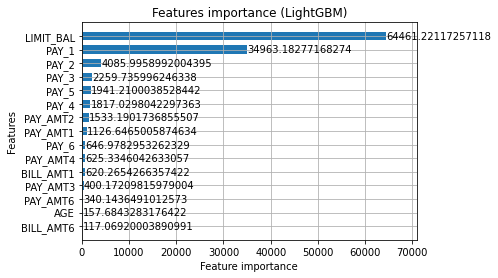

In [8]:
# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
plt.show()

We notice that the synthetic feature `LIMIT_BAL` appears as the most important feature in this model although it has no predictive power for an entire demographic segment in the data (as you can recall, we transformed the feature as to be highly predictive for "female" group, but as to provide no information about the "male" group's target value - namely the probability to default).

We next use Fairlearn's `MetricFrame` to examine the the two different kinds of errors (false positives and false negatives) on the test data.

In [9]:
mf = MetricFrame(
    metrics = {
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    y_true = Y_test, 
    y_pred = test_preds, 
    sensitive_features = A_str_test)

mf.by_group

,FPR,FNR
SEX,,
female,0.139423,0.152098
male,0.151079,0.497048


Note that both kinds of errors are more common in the "male" group than in the "female" group.

In [10]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        " ------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
                "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
    }
    
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

We calculate several performance and fairness metrics below:

In [11]:
# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated
Overall selection rate,0.267111
Demographic parity difference,0.049941
Demographic parity ratio,0.825666
------,
False positive rate difference,0.011656
False negative rate difference,0.344951
Equalized odds difference,0.344951
------,
Overall AUC,0.852206
AUC difference,0.189891


As the overall performance metric we use the _area under ROC curve_ (AUC), which is suited to classification problems with a large imbalance between positive and negative examples. For binary classifiers, this is the same as _balanced accuracy_.

As the fairness metric we use *equalized odds difference*, which quantifies the disparity in accuracy experienced by different demographics. Our goal is to assure that neither of the two groups ("male" vs "female") has substantially larger FP or FN rates. The equalized odds difference is equal to the larger of the following two numbers: (1) the difference between false-positive rates of the two groups, (2) the difference between false-negative rates of the two groups.

The table above shows the overall AUC of 0.85 (based on continuous predictions) and the overall balanced error rate of 0.22 (based on 0/1 predictions). Both of these are satisfactory in our application context. However, there is a large disparity in accuracy rates (as indicated by the balanced error rate difference) and even larger when we consider the equalized-odds difference. 

## Mitigating Equalized Odds Difference with Postprocessing

We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. 

#### Before applying postprocessing 
Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that ThresholdOptimizer is effectively optimizing balanced accuracy on the original data.

In [12]:
# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)

df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

#### Fitting the algorithm

In [13]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)

postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

/usr/local/lib/python3.7/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:275: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:309: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
  type(s

#### Compare metrics before and after mitigation

In [14]:
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.267111,0.083444
Demographic parity difference,0.049941,0.005592
Demographic parity ratio,0.825666,0.935627
------,,
False positive rate difference,0.011656,0.003489
False negative rate difference,0.344951,0.017505
Equalized odds difference,0.344951,0.017505
------,,
Overall AUC,0.852206,0.597663
AUC difference,0.189891,0.010497


The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (overall balanced error rate as well as overall AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.


## Mitigating Equalized Odds Difference with GridSearch (Reductions)

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

In [15]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=50,
                   grid_limit=3)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_] 

equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use g

In [16]:
# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

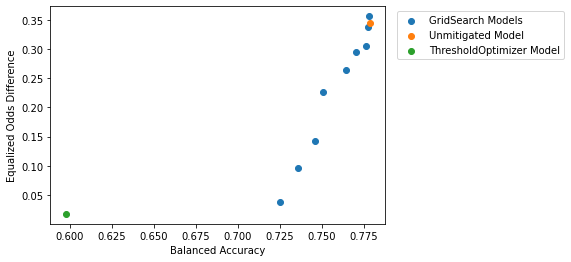

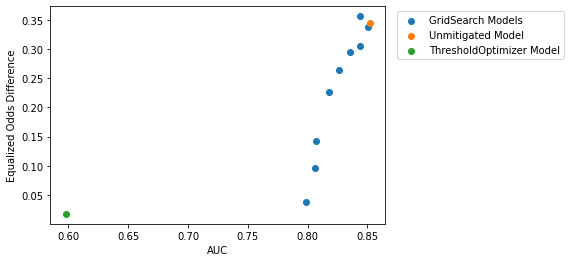

In [17]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

# Plot equalized odds difference vs AUC
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

As intended, `GridSearch` models appear along the trade-off curve between the large balanced accuracy (but also large disparity), and low disparity (but worse balanced accuracy). This gives the data scientist a flexibility to select a model that fits the application context best.

Similarly, `GridSearch` models appear along the trade-off curve between AUC and equalized odds difference.

In [18]:
# Compare GridSearch models with low values of equalized odds difference with the previously constructed models
grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                    for i in range(len(sweep_preds))
                    if non_dominated[i] and equalized_odds_sweep[i]<0.1}
models_dict.update(grid_search_dict)
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer,GridSearch_39,GridSearch_40
Overall selection rate,0.267111,0.083444,0.267889,0.254333
Demographic parity difference,0.049941,0.005592,0.021348,0.033651
Demographic parity ratio,0.825666,0.935627,0.924019,0.877607
------,,,,
False positive rate difference,0.011656,0.003489,0.034745,0.034128
False negative rate difference,0.344951,0.017505,0.09688,0.037394
Equalized odds difference,0.344951,0.017505,0.09688,0.037394
------,,,,
Overall AUC,0.852206,0.597663,0.80592,0.798488
AUC difference,0.189891,0.010497,0.063422,0.053103


The selected sweeps from the `GridSearch` algorithm significantly reduced the disparity across multiple metrics (false positive/negative rate difference, equalized odds difference), while maintaining an acceptable accuracy. 



## Conclusion

In this notebook, we first trained a simple model and computed several fairness metrics on the prediction scores. After that, we tried to mitigate the present biases with a postprocessed `ThresholdOptimizer` model and a reductions `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.